### Preamble

In [33]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels as fm
import FwtModels.dof2 as dof2
import FwtModels.RollingModel as rm
import FwtModels.AeroModels as ams
import FwtModels.AssumedShapesNonLin as asnl

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [34]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = fm.FwtParameters(3)

## Create some global parameters
p.c = fm.FwtVariable(0.15,'c') # chord of wing

p.s_t = fm.FwtVariable(10,'s_t') # wing total span
p.sigma = fm.FwtVariable(0.2,'sigma') # FWT as percentage of total span

# main Wing Structural Parameters
p.y_w = sym.Symbol('y_w')
p.x_w = sym.Symbol('x_w')


p.x_fw = p.c*half # flexural axis location
#p.c_w = p.c # chord of main wing
p.s_w = p.s_t * (1-p.sigma) # span
p.EI = fm.FwtVariable(1e9,'EI') # EI
p.GJ = fm.FwtVariable(1e7,'GJ') # GJ

p.m_w = fm.FwtVariable(30,'m_t') # inner wing mass
p.rho_w = p.m_w/(p.c*p.s_w) #wing density

# FWT structural Parameters
p.Lambda = fm.FwtVariable(np.deg2rad(10),'Lambda') # flare angle
p.y_f = fm.FwtVariable(0,'y_f') # spanwise location
p.m_f = fm.FwtVariable(2,'m_f') # mass of the folding wing tip
p.s_f = p.s_t * p.sigma # span of the folding wing tip
p.l_f = p.s_f*sym.Rational(1,2) # location of FWT CoM from Hinge

p.I_xx_f = sym.Rational(1,12)*p.m_f*p.s_f**2 # inertia of FWT (uniform bar)

## Aero Parameters
p.rho = fm.FwtVariable(1.225,'rho') # density
p.V = fm.FwtVariable(10,'V') # velocity
p.g  = fm.FwtVariable(9.81,'g') # gravity
p.alpha_r = fm.FwtVariable(np.deg2rad(3),'alpha_r') # root AoA

p.a_w = fm.FwtVariable(2*np.pi,'a_w') # C_L of wing
p.a_f = p.a_w - p.a_w*p.y_f/p.s_f # C_L of fwt

#### Create Transforms

In [38]:
#get shape functions for main wing
z_w,tau_w = asnl.ShapeFunctions_BN_TM(2,1,p.q[:3],p.y_w,p.x_w,p.x_fw,0)

#define wing frame
wing_frame = symt.HomogenousTransform()

#create flexielement
M = fm.MassMatrix(p.rho_w)
ele = fm.FlexiElement(wing_frame,sym.Matrix([0,tau_w,0]),M,p.x_w,p.y_w,z_w,-p.c,p.s_w,p.x_fw,p.EI,p.GJ)

# get expression for z and alpha at the end of the main wing
z_f = z_w.subs({p.x_w:p.c*half,p.y_w:p.s_w})
tau_f = tau_w.subs({p.y_w:p.s_w})

# define FWT Frame
fwt_frame = wing_frame.Translate(-p.c*half,p.s_w,z_f).R_y(tau_f)#.R_x(p.q[-1]) #

rot_fwt = sym.Matrix([p.q[-1],p.alpha_r+tau_f,0])

# FWT Mass Matrix
M_fwt = fm.MassMatrix(p.m_f,I_xx = p.I_xx_f)

# FWT element
bar_fwt = fm.RigidElement(fwt_frame.Translate(0,p.l_f,0),rot_fwt,M_fwt)

# Gravitational Forces
fwt_GravityForces = ams.GravityModel(p,fwt_frame.Translate(0,p.l_f,0),sym.Matrix([0,0,p.g*p.m_f]))
#wing_GravityForces = ams.GravityModel(p,wing_frame,sym.Matrix([0,0,p.g*p.m_w]))

#Aero Forces
fwt_AeroForces = ams.AeroModelv2(p,fwt_frame.Translate(0,p.y_f,0),p.a_f,(p.y_f,0,p.s_f),ams.FwtAoA(p,p.q[2])+tau_f)

wing_frame_aero = wing_frame.Translate(0,p.y_w,0)
wing_AeroForces = ams.AeroModelv2(p,wing_frame_aero,p.a_w,(p.y_w,0,p.s_w),p.alpha_r+tau_w)

#compistie force
CompositeForce = ams.CompositeForce([fwt_GravityForces])

sm = asnl.SymbolicModel([ele,bar_fwt],p)

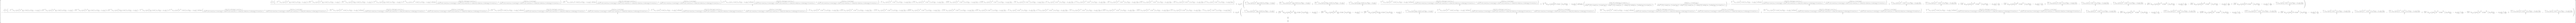

In [46]:
fwt_AeroForces.Q()

## create masses 

In [42]:
tmax, dt = 10, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 25

def arfunc(t,x):
    return np.deg2rad(0)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)

p.V.value = Vfunc
p.alpha_r.value = arfunc

y0 = [0]*p.qs*2
y0[0] = 0.2
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

In [43]:
objectiveDeriv(0,[0]*p.qs*2)
#[0]*int(len([0,0,0,0,0,0])/2)

<string>:4: RuntimeWarning: overflow encountered in double_scalars
C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\1-PythonFwtModels\Workbooks\5_Non-linear FWTD Assumed Shapes\..\..\FwtModels\AssumedShapesNonLin\symbolic_model.py:85: RuntimeWarning: invalid value encountered in matmul
  accels = np.linalg.inv(self.M_func(*tup,x))@(-self.f_func(*tup,external,x))
<string>:4: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 't [s]')

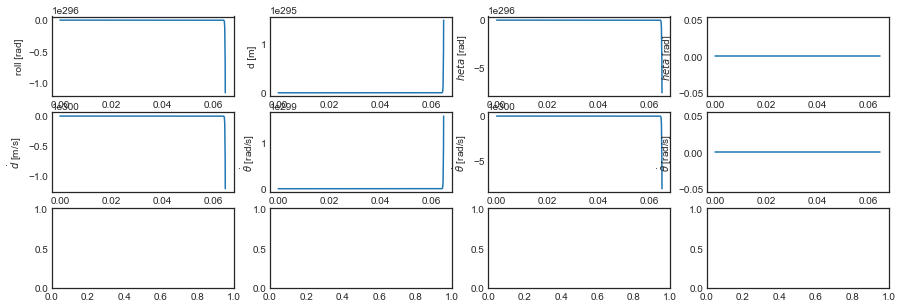

In [44]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

# interpolate data onto a uniform time grid

yi = yData.y
t = yData.t

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(3,4,figsize=(15,5))

# roll plot
axes[0][0].plot(t,yi[0])
axes[0][0].set_ylabel('roll [rad]')
axes[0][0].set_xlabel('t [s]')

# d plot
axes[0][1].plot(t,yi[2])
axes[0][1].set_ylabel('d [m]')
axes[0][1].set_xlabel('t [s]')

# theta plot
axes[0][2].plot(t,yi[4])
axes[0][2].set_ylabel('$\theta$ [rad]')
axes[0][2].set_xlabel('t [s]')


# theta plot
axes[0][3].plot(t,yi[6])
axes[0][3].set_ylabel('$\theta$ [rad]')
axes[0][3].set_xlabel('t [s]')

# ddot plot
axes[1][0].plot(t,yi[1])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[3])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# thetadot plot
axes[1][2].plot(t,yi[5])
axes[1][2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][2].set_xlabel('t [s]')
# thetadot plot
axes[1][3].plot(t,yi[7])
axes[1][3].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][3].set_xlabel('t [s]')

In [12]:
yData

  message: 'Required step size is less than spacing between numbers.'
     nfev: 536
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 1.00000000e-04, 2.17093898e-04, 3.56893948e-04,
       5.08020969e-04, 6.60808676e-04, 8.13596382e-04, 9.66384089e-04,
       1.11917180e-03, 1.14972934e-03, 1.16897264e-03, 1.19255945e-03,
       1.20642233e-03, 1.21512739e-03, 1.22083595e-03, 1.22366799e-03,
       1.22487651e-03, 1.22555876e-03, 1.22585981e-03, 1.22600084e-03,
       1.22606471e-03, 1.22609342e-03, 1.22610609e-03, 1.22611162e-03,
       1.22611402e-03, 1.22611505e-03, 1.22611549e-03, 1.22611568e-03,
       1.22611576e-03, 1.22611579e-03, 1.22611581e-03, 1.22611582e-03,
       1.22611582e-03, 1.22611582e-03, 1.22611582e-03, 1.22611582e-03,
       1.22611582e-03, 1.22611582e-03, 1.22611582e-03, 1.22611582e-03,
       1.22611582e-03, 1.22611582e-03, 1.22611582e-03, 1.22611582e-03,
       1.22611582e-03, 1.22611582e-03, 1.22611582e